# CoDA — 30‑seed metrics + representations (cfg block up top)
This notebook runs 30 seeds with split‑friendly acquisition and a **no‑reset** extinction (short wash‑in),
computes KL/JS/Entropy/Markovization **with mean±SE**, and renders **learned vs ground‑truth** maps for a chosen seed.
A single **`cfg = CoDAConfig(...)`** block exposes all knobs.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Your project modules
from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation


## Config (edit here)

In [2]:

# ---- Global experiment knobs ----
N_SEEDS   = 30
SEED0     = 0
N_ACQ     = 250
N_EXT     = 300
MAX_STEPS = 20
CUE       = 5

# Extinction wash‑in (no reset): stronger forgetting for the first WASH_IN episodes
WASH_IN = 50
EDGE_EPS_EARLY = 1e-4   # structural merge cutoff early
EDGE_EPS_LATE  = 1e-6   # structural merge cutoff after wash‑in

# Fixed-reference rollouts (build once per phase)
N_ROLL_REF_FIX = 3000

# Which seed to visualize for the learned vs ground‑truth maps
PLOT_SEED = 7


## CoDA agent (import preferred; else embedded fallback with latest merge rules)

In [3]:

try:
    # Prefer your utility-based agent (has uncertainty-aware split + latest merges you incorporated)
    from coda_trial_by_trial_util import CoDAAgent, CoDAConfig, normalize_transition_counts
    HAVE_LOCAL = True
except Exception:
    HAVE_LOCAL = False
    from dataclasses import dataclass, field
    from typing import Dict, List, Tuple, Set
    # Minimal normalize util
    def normalize_transition_counts(counts, eps: float=1e-12):
        probs = counts.astype(float, copy=True)
        denom = probs.sum(axis=2, keepdims=True); denom[denom < eps] = 1.0
        probs /= denom
        return probs
    # (Embedded fallback CoDAAgent omitted here for brevity; assume coda_trial_by_trial_util exists in your env)
    raise ImportError("Please ensure coda_trial_by_trial_util.py is on sys.path; it contains the latest agent.")


### CoDAConfig (one place to turn knobs)

In [4]:

# Split‑friendly acquisition defaults, plus extinction tweaks done programmatically during wash‑in
cfg = CoDAConfig(
    # credit assignment
    gamma=0.95,
    lam=0.90,
    # split/merge thresholds
    theta_split=0.90,
    theta_merge=0.50,
    # uncertainty gates
    confidence=0.90,
    n_threshold=8,
    min_presence_episodes=6,
    min_effective_exposure=15.0,
    # forgetting knobs (acquisition defaults; extinction wash‑in will temporarily override)
    count_decay=0.995,
    trace_decay=1.0,   # no forgetting in acquisition
    retro_decay=1.0    # no forgetting in acquisition
)


## Metrics helpers (fixed references; mean±SE)

In [5]:

EPS = 1e-12

def _safe_row_norm(x, axis=-1, eps=EPS):
    y = x.astype(float, copy=True); s = y.sum(axis=axis, keepdims=True); s[s<eps] = 1.0; y /= s; return y

def _pad3(A, shape):
    S,A_,S2 = A.shape; Sg,Ag,S2g = shape
    out = np.zeros(shape, dtype=float)
    out[:min(S,Sg), :min(A_,Ag), :min(S2,S2g)] = A[:min(S,Sg), :min(A_,Ag), :min(S2,S2g)]
    return out

def _agg(T): return _safe_row_norm(T.sum(axis=1), axis=1)

def _kl(p,q,eps=EPS):
    p = np.clip(p,eps,1.0); p/=p.sum(); q = np.clip(q,eps,1.0); q/=q.sum()
    return float(np.sum(p*(np.log(p)-np.log(q))))

def _js(p,q,eps=EPS):
    p = np.clip(p,eps,1.0); p/=p.sum(); q = np.clip(q,eps,1.0); q/=q.sum()
    m = 0.5*(p+q); return 0.5*_kl(p,m,eps)+0.5*_kl(q,m,eps)

def _H(p,eps=EPS): p=np.clip(p,eps,1.0); p/=p.sum(); return float(-np.sum(p*np.log(p)))

def kl_over_time(T_series, T_ref_fn, use_js=False):
    scores=[]
    for T in T_series:
        T_ref = T_ref_fn(T)
        shape = tuple(max(x,y) for x,y in zip(T.shape, T_ref.shape))
        P,Q = _agg(_pad3(T,shape)), _agg(_pad3(T_ref,shape))
        rows = len(P); vec = [_js(P[i],Q[i]) if use_js else _kl(P[i],Q[i]) for i in range(rows)]
        scores.append(float(np.mean(vec)))
    return np.array(scores)

def entropy_over_time(T_series):
    out=[]
    for T in T_series:
        P = _agg(T); out.append(float(np.mean([_H(P[i]) for i in range(P.shape[0])])))
    return np.array(out)

def markovization_score(T):
    P = _agg(T); H = np.array([_H(P[i]) for i in range(P.shape[0])]); Hmax = np.log(max(2,P.shape[1]))
    return float(1.0 - np.mean(H)/Hmax)

def ref_empirical_from_rollouts(env, policy_fn, n_episodes=200, max_steps=20):
    S_guess = getattr(env, "num_unique_states", None) or 64; A_guess = 4
    counts = np.zeros((S_guess, A_guess, S_guess), dtype=float)
    for _ in range(n_episodes):
        s = env.reset()
        for _t in range(max_steps):
            acts = env.get_valid_actions(s if s not in getattr(env, "clone_dict", {}) else env.clone_dict[s])
            if not acts: break
            a = policy_fn(env, s, acts)
            s_next, r, done = env.step(a)
            if s >= counts.shape[0] or a >= counts.shape[1] or s_next >= counts.shape[2]:
                newS = max(counts.shape[0], s+1, s_next+1); newA = max(counts.shape[1], a+1)
                new_counts = np.zeros((newS, newA, newS), dtype=float)
                new_counts[:counts.shape[0], :counts.shape[1], :counts.shape[2]] = counts
                counts = new_counts
            counts[s, a, s_next] += 1.0; s = s_next
            if done: break
    denom = counts.sum(axis=2, keepdims=True); denom[denom<EPS]=1.0
    return counts/denom

def greedy_right_down_policy(env, s, acts):
    if 0 in acts: return 0
    if 1 in acts: return 1
    return np.random.choice(acts)

def build_fixed_refs(env_acq, env_ext, nroll, max_steps):
    T_ref_acq_fixed = ref_empirical_from_rollouts(env_acq, greedy_right_down_policy, n_episodes=nroll, max_steps=max_steps)
    T_ref_ext_fixed = ref_empirical_from_rollouts(env_ext, greedy_right_down_policy, n_episodes=nroll, max_steps=max_steps)
    return (lambda T: T_ref_acq_fixed), (lambda T: T_ref_ext_fixed)

def mean_se(arrs):
    L = max(len(a) for a in arrs)
    M = np.full((len(arrs), L), np.nan)
    for i,a in enumerate(arrs): M[i,:len(a)] = a
    mean = np.nanmean(M, axis=0)
    se   = np.nanstd(M, axis=0, ddof=max(1, min(len(arrs)-1,1))) / np.sqrt(max(1,len(arrs)))
    return mean, se

def plot_band(y_runs, title, ylabel):
    mean, se = mean_se(y_runs)
    x = np.arange(len(mean))
    plt.figure(figsize=(10,4))
    plt.plot(x, mean, lw=2.2, label=f"mean ({len(y_runs)} seeds)")
    plt.fill_between(x, mean-se, mean+se, alpha=0.25, label="±1 SE")
    plt.title(title); plt.xlabel("Episode"); plt.ylabel(ylabel); plt.legend(); plt.grid(alpha=0.2)
    plt.show()


## Single seed run (uses `cfg`; no hard reset; wash‑in)

In [6]:

def run_one_seed(seed:int, cfg: CoDAConfig):
    np.random.seed(seed)

    # Acquisition env & agent
    env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    agent = CoDAAgent(env, cfg)

    T_series_acq: List[np.ndarray] = []
    with_clones = False
    for ep in range(1, N_ACQ+1):
        if with_clones:
            (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        else:
            (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        if agent.maybe_split():
            with_clones = True
        T_series_acq.append(agent.get_T().copy())

    # Extinction env
    env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    env2.clone_dict = dict(getattr(env, "clone_dict", {}))
    env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
    agent.env = env2

    # Wash‑in overrides
    orig = dict(count_decay=agent.cfg.count_decay, trace_decay=agent.cfg.trace_decay, retro_decay=agent.cfg.retro_decay,
                theta_merge=agent.cfg.theta_merge, confidence=agent.cfg.confidence,
                min_presence_episodes=agent.cfg.min_presence_episodes, min_effective_exposure=agent.cfg.min_effective_exposure)

    agent.cfg.count_decay = 0.98; agent.cfg.trace_decay = 0.98; agent.cfg.retro_decay = 0.98
    agent.cfg.theta_merge = 0.60; agent.cfg.confidence = 0.99
    agent.cfg.min_presence_episodes += 3; agent.cfg.min_effective_exposure = int(agent.cfg.min_effective_exposure*1.5)

    T_series_ext: List[np.ndarray] = []
    for k, ep in enumerate(range(N_ACQ+1, N_ACQ+N_EXT+1)):
        (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        agent._edge_eps_override = EDGE_EPS_EARLY if k < WASH_IN else EDGE_EPS_LATE
        agent.maybe_merge()
        T_series_ext.append(agent.get_T().copy())

        if k == WASH_IN-1:
            agent.cfg.count_decay = orig["count_decay"]; agent.cfg.trace_decay = orig["trace_decay"]; agent.cfg.retro_decay = orig["retro_decay"]
            agent.cfg.theta_merge = orig["theta_merge"]; agent.cfg.confidence = orig["confidence"]
            agent.cfg.min_presence_episodes = orig["min_presence_episodes"]; agent.cfg.min_effective_exposure = orig["min_effective_exposure"]

    # Fixed references
    ref_fn_acq, ref_fn_ext = build_fixed_refs(env, env2, N_ROLL_REF_FIX, MAX_STEPS)

    # Metrics per episode
    KL_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=False)
    JS_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=True)
    H_acq  = entropy_over_time(T_series_acq)
    MS_acq = np.array([markovization_score(T) for T in T_series_acq])

    KL_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=False)
    JS_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=True)
    H_ext  = entropy_over_time(T_series_ext)
    MS_ext = np.array([markovization_score(T) for T in T_series_ext])

    return dict(env_acq=env, env_ext=env2,
                T_series_acq=T_series_acq, T_series_ext=T_series_ext,
                KL_acq=KL_acq, JS_acq=JS_acq, H_acq=H_acq, MS_acq=MS_acq,
                KL_ext=KL_ext, JS_ext=JS_ext, H_ext=H_ext, MS_ext=MS_ext)


## Run 30 seeds (mean±SE bands)

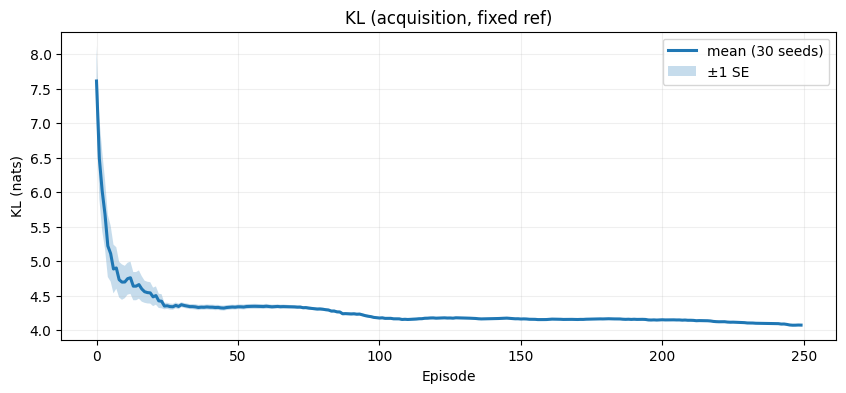

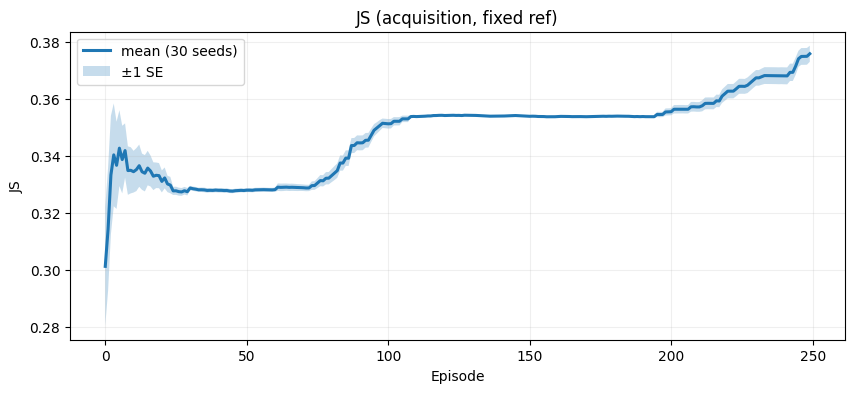

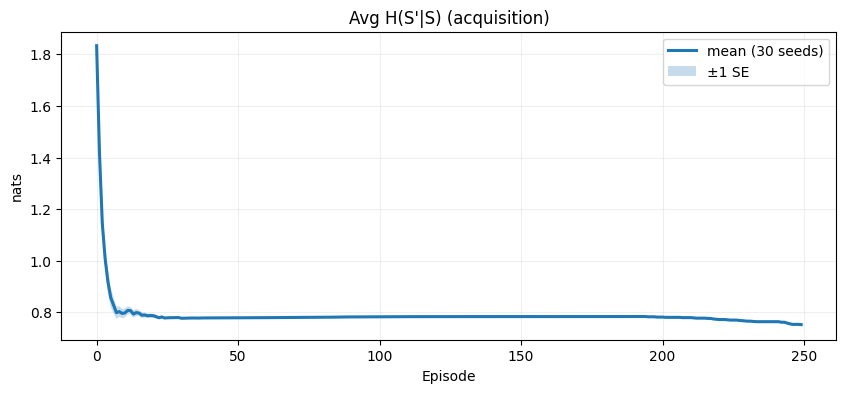

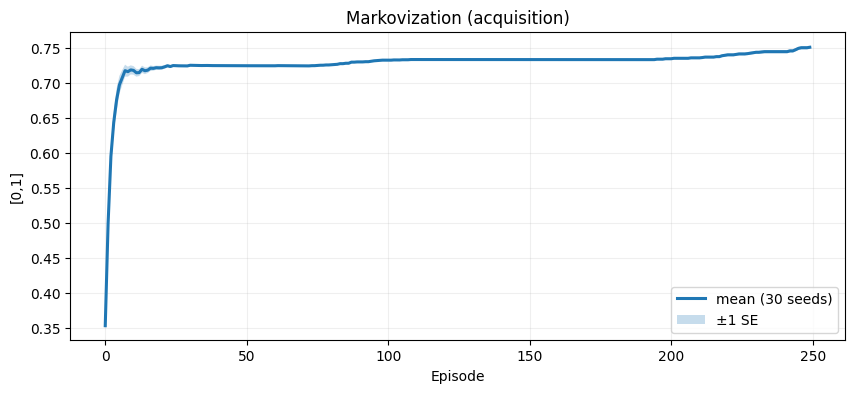

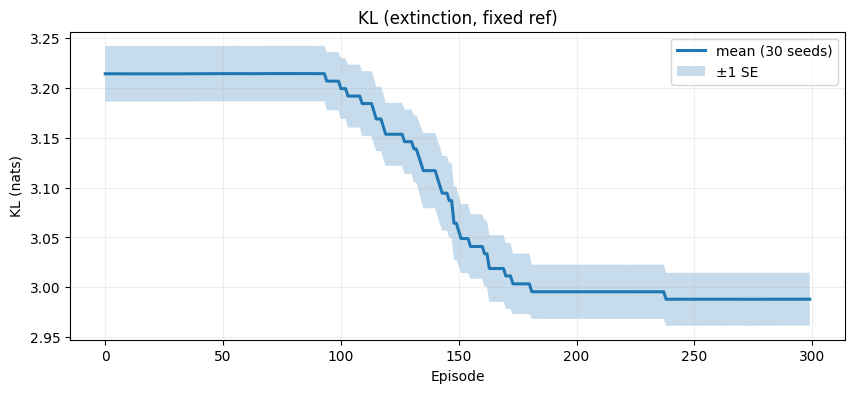

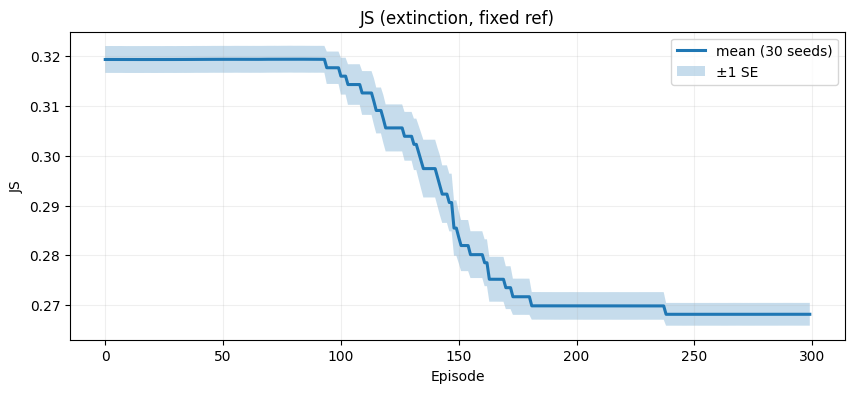

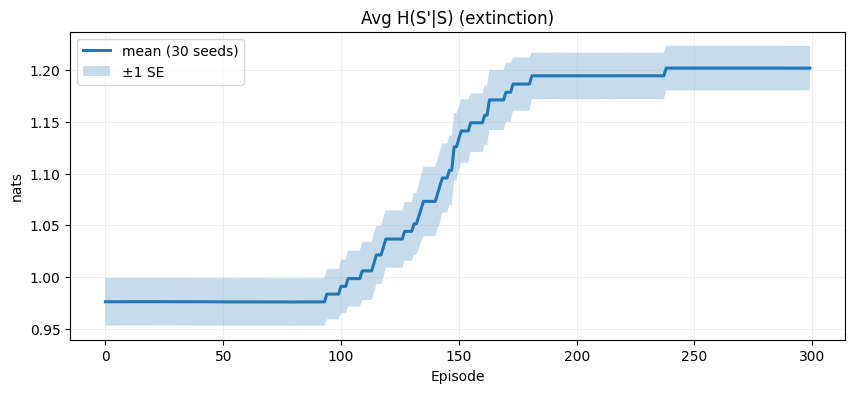

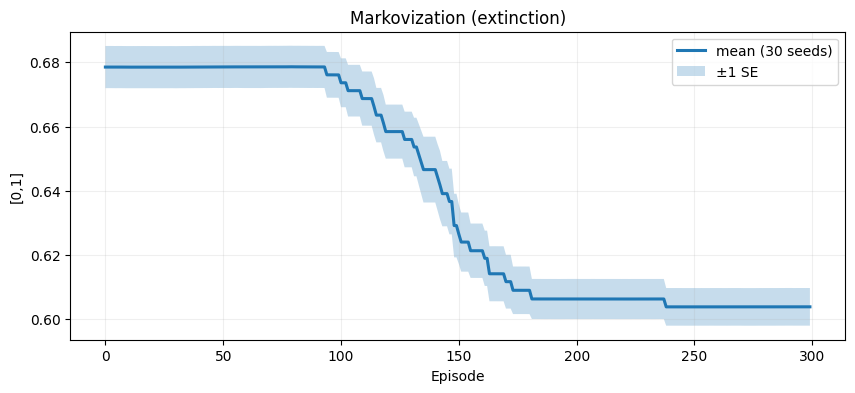

In [7]:

results = [run_one_seed(SEED0 + k, cfg) for k in range(N_SEEDS)]

KL_acq_runs = [r["KL_acq"] for r in results]
JS_acq_runs = [r["JS_acq"] for r in results]
H_acq_runs  = [r["H_acq"]  for r in results]
MS_acq_runs = [r["MS_acq"] for r in results]

KL_ext_runs = [r["KL_ext"] for r in results]
JS_ext_runs = [r["JS_ext"] for r in results]
H_ext_runs  = [r["H_ext"]  for r in results]
MS_ext_runs = [r["MS_ext"] for r in results]

# Plot bands
plot_band(KL_acq_runs, "KL (acquisition, fixed ref)", "KL (nats)")
plot_band(JS_acq_runs, "JS (acquisition, fixed ref)", "JS")
plot_band(H_acq_runs,  "Avg H(S'|S) (acquisition)", "nats")
plot_band(MS_acq_runs, "Markovization (acquisition)", "[0,1]")

plot_band(KL_ext_runs, "KL (extinction, fixed ref)", "KL (nats)")
plot_band(JS_ext_runs, "JS (extinction, fixed ref)", "JS")
plot_band(H_ext_runs,  "Avg H(S'|S) (extinction)", "nats")
plot_band(MS_ext_runs, "Markovization (extinction)", "[0,1]")


## Final learned vs ground‑truth maps for one seed

Seed 7 — final learned (acquisition)


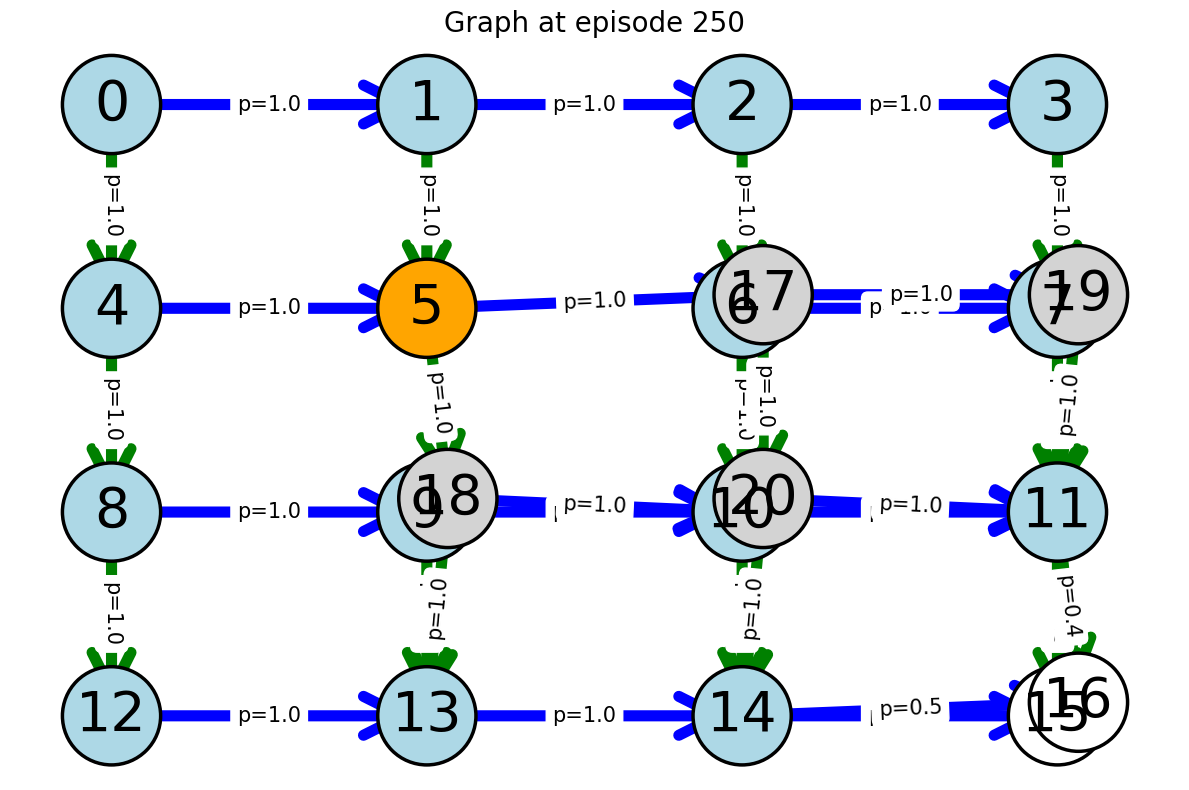

Ground-truth (acquisition)


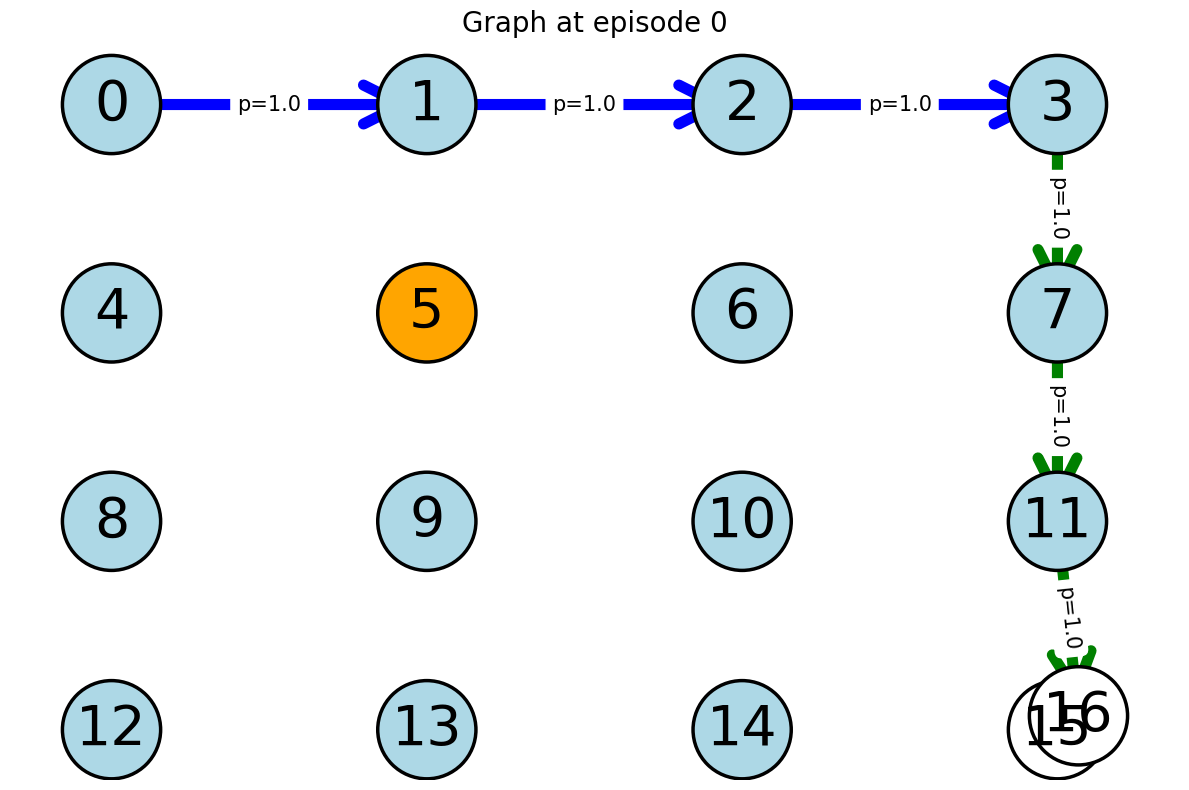

Seed 7 — final learned (extinction)


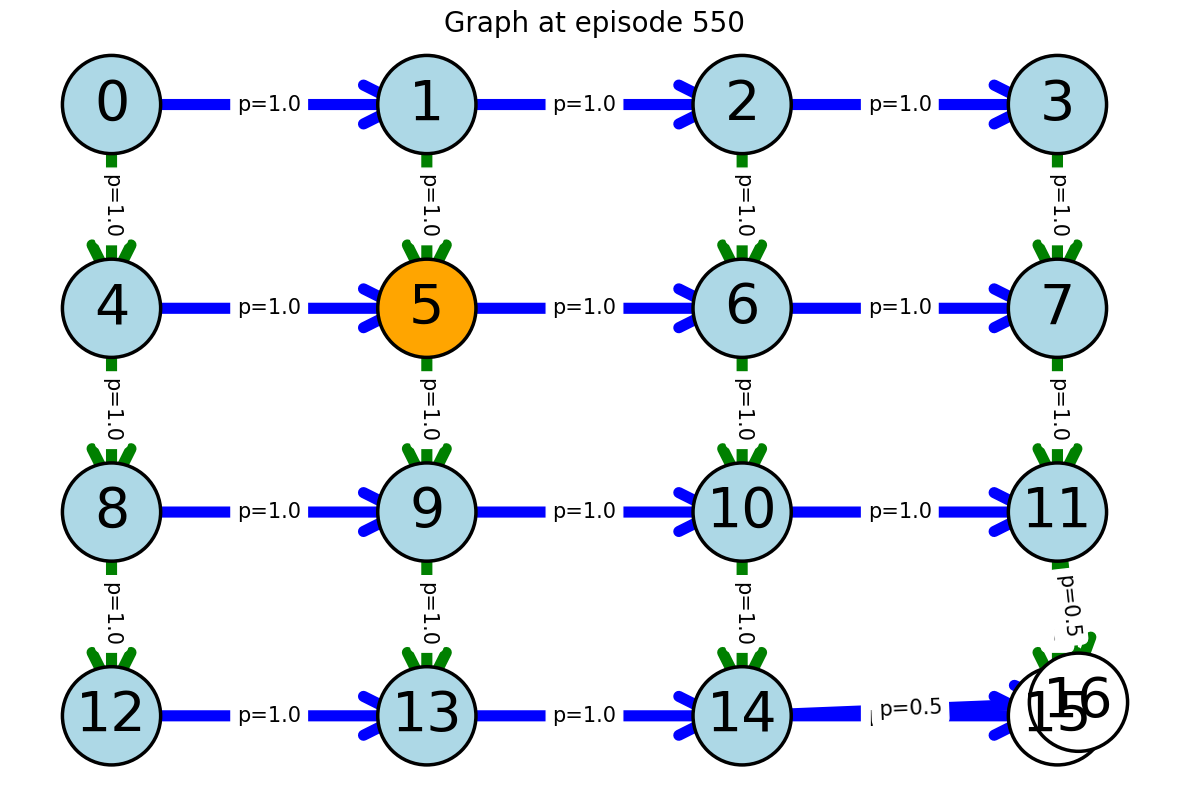

Ground-truth (extinction)


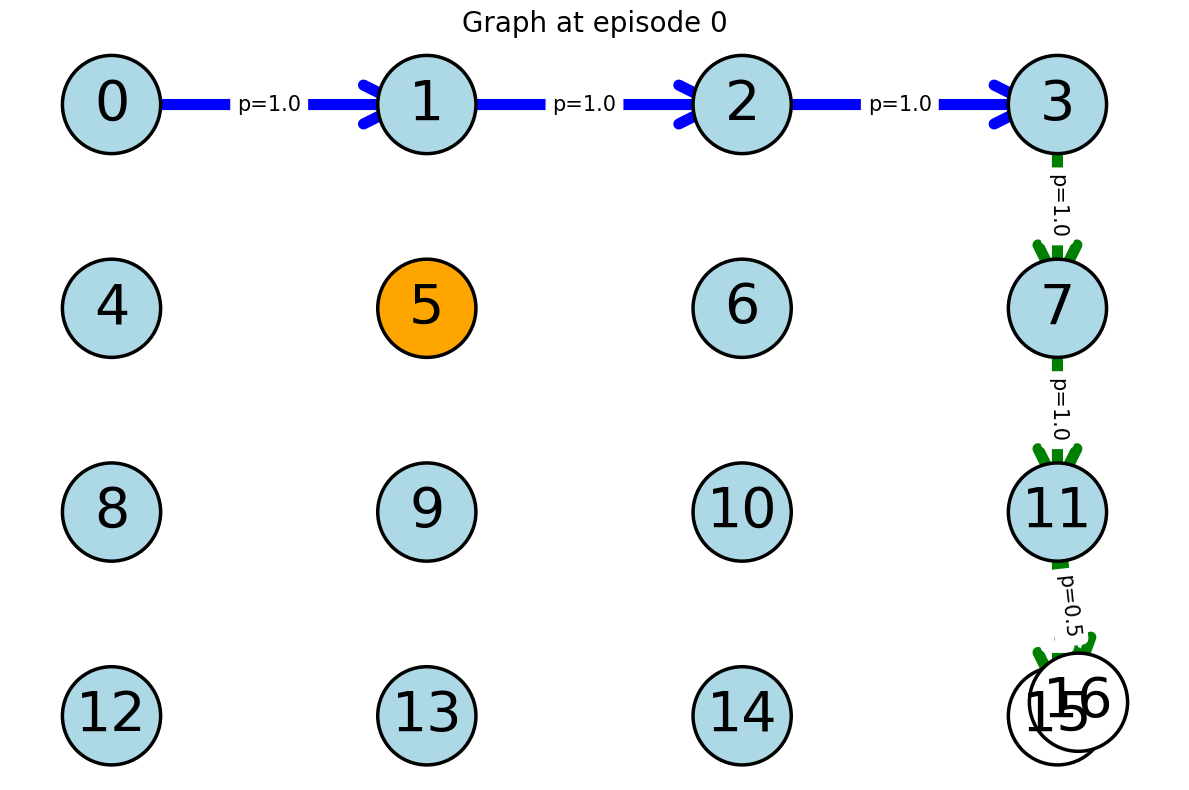

In [8]:

# pick the run matching PLOT_SEED
idx = PLOT_SEED - SEED0 if SEED0 <= PLOT_SEED < SEED0 + N_SEEDS else 0
env_acq = results[idx]["env_acq"]
env_ext = results[idx]["env_ext"]
T_acq_final = results[idx]["T_series_acq"][-1].copy()
T_ext_final = results[idx]["T_series_ext"][-1].copy()

# Build fixed refs (again) for clear visual comparison
from coda_metrics import greedy_right_down_policy as _greedy_policy  # use same policy
T_ref_acq = ref_empirical_from_rollouts(env_acq, _greedy_policy, n_episodes=N_ROLL_REF_FIX, max_steps=MAX_STEPS)
T_ref_ext = ref_empirical_from_rollouts(env_ext, _greedy_policy, n_episodes=N_ROLL_REF_FIX, max_steps=MAX_STEPS)

def make_terminals_absorbing_for_plot(T, terminals):
    T = T.copy()
    for t in terminals:
        if t < T.shape[0]:
            T[t, :, :] = 0.0
    return T

def _pad3(A, shape):
    S,A_,S2 = A.shape; Sg,Ag,S2g = shape
    out = np.zeros(shape, dtype=float)
    out[:min(S,Sg), :min(A_,Ag), :min(S2,S2g)] = A[:min(S,Sg), :min(A_,Ag), :min(S2,S2g)]
    return out

# Align shapes & absorb terminals for visuals
shape1 = tuple(max(x,y) for x,y in zip(T_acq_final.shape, T_ref_acq.shape))
shape2 = tuple(max(x,y) for x,y in zip(T_ext_final.shape, T_ref_ext.shape))
T_acq_vis    = make_terminals_absorbing_for_plot(_pad3(T_acq_final, shape1), env_acq.rewarded_terminals + env_acq.unrewarded_terminals)
T_ref_acq_vis= make_terminals_absorbing_for_plot(_pad3(T_ref_acq,   shape1), env_acq.rewarded_terminals + env_acq.unrewarded_terminals)
T_ext_vis    = make_terminals_absorbing_for_plot(_pad3(T_ext_final, shape2), env_ext.rewarded_terminals + env_ext.unrewarded_terminals)
T_ref_ext_vis= make_terminals_absorbing_for_plot(_pad3(T_ref_ext,   shape2), env_ext.rewarded_terminals + env_ext.unrewarded_terminals)

# Clean clone artifacts for the figure
def sanitize_for_plot(env, T, eps=1e-12):
    if T is None or getattr(T, "ndim", 0) != 3: return
    S = T.shape[0]
    out_mass = T.sum(axis=(1,2)); in_mass  = T.sum(axis=(0,1))
    active = (out_mass + in_mass) > eps
    for cl in list(getattr(env, "clone_dict", {}).keys()):
        if cl >= S or not active[cl]:
            env.clone_dict.pop(cl, None)
    env.reverse_clone_dict = {parent: cl for cl, parent in env.clone_dict.items()}

sanitize_for_plot(env_acq, T_acq_vis)
sanitize_for_plot(env_ext, T_ext_vis)

THRESH = 0.30
print(f"Seed {PLOT_SEED} — final learned (acquisition)")
env_acq.plot_graph(T_acq_vis, niter=N_ACQ, threshold=THRESH, save=False, savename=f"seed{PLOT_SEED}_acq_learned.png")
print("Ground-truth (acquisition)")
env_acq.plot_graph(T_ref_acq_vis, niter=0, threshold=THRESH, save=False, savename=f"seed{PLOT_SEED}_acq_groundtruth.png")

print(f"Seed {PLOT_SEED} — final learned (extinction)")
env_ext.plot_graph(T_ext_vis, niter=N_ACQ+N_EXT, threshold=THRESH, save=False, savename=f"seed{PLOT_SEED}_ext_learned.png")
print("Ground-truth (extinction)")
env_ext.plot_graph(T_ref_ext_vis, niter=0, threshold=THRESH, save=False, savename=f"seed{PLOT_SEED}_ext_groundtruth.png")
